## Base Root

In [2]:
import numpy as np
import pandas as pd

## Sub-sampling

In [3]:
import csv
import random

def reservoir_sampling(iterable, k, header=True):
    reservoir = []
    for i, item in enumerate(iterable):
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
    return reservoir

# Open the input CSV file
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv") as f:
    # Check if header line exists
    header = True
    first_line = f.readline()
    if not first_line.startswith('step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'):
        header = False
        f.seek(0)  # Rewind file pointer to beginning

    # Sample from remaining lines
    sampled_lines = reservoir_sampling(f, k=800000, header=header)

# Open the output CSV file and write the subsample to it
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    if header:
        writer.writerow(first_line.strip().split(','))
    for line in sampled_lines:
        writer.writerow(line.strip().split(','))

In [4]:
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [5]:
df_sample.shape

(800000, 11)

In [6]:
df_sample.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,233,PAYMENT,9331.34,C263415670,15967.00,6635.66,M699431418,0.00,0.00,0,0
1,404,PAYMENT,7661.62,C1162660376,133737.98,126076.37,M693790744,0.00,0.00,0,0
2,334,CASH_IN,342241.91,C1531009256,4860266.74,5202508.65,C1107377692,3576462.82,3234220.92,0,0
3,402,PAYMENT,9791.66,C417474232,21108.00,11316.34,M830957991,0.00,0.00,0,0
4,373,CASH_OUT,192880.23,C761310285,19287.00,0.00,C402195295,2566422.75,2759302.98,0,0


## Data type conversion

In [7]:
# Change the data type of column 'A' from float64 to float32
df_sample['amount'] = df_sample['amount'].astype('float32')
df_sample['oldbalanceOrg'] = df_sample['oldbalanceOrg'].astype('float32')
df_sample['oldbalanceDest'] = df_sample['oldbalanceDest'].astype('float32')
df_sample['newbalanceOrig'] = df_sample['newbalanceOrig'].astype('float32')
df_sample['newbalanceDest'] = df_sample['newbalanceDest'].astype('float32')

In [8]:
df_sample['step'] = df_sample['step'].astype('int32')
df_sample['isFlaggedFraud'] = df_sample['isFlaggedFraud'].astype('int32') 
df_sample['isFraud'] = df_sample['isFraud'].astype('int32') 

## Feature encoding

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['type'])
label
df_sample.drop("type", axis=1, inplace=True)
df_sample["type"] = label

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

## Train-test split

In [12]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.99872
1    0.00128
Name: isFraud, dtype: float64
0    0.998719
1    0.001281
Name: isFraud, dtype: float64
0    0.998725
1    0.001275
Name: isFraud, dtype: float64


## Class imbalance

## SMOTE & UnderSampler

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set up the resampling methods
smote = SMOTE(sampling_strategy=0.2, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

# Apply the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [14]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_resampled)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 205450
Class 1 count: 143815


## Tomeks

In [15]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection

# Assume X_train and y_train are the original training data
# resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [16]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_train_resampled)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 205438
Class 1 count: 143815


## ENN

In [17]:
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [18]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_train_resampled_new)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 202888
Class 1 count: 143815


## OSS

In [19]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [20]:
import numpy as np

counts = np.bincount(y_train_resampled_final)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 183288
Class 1 count: 143815


In [21]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_test)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 79898
Class 1 count: 102


In [22]:
y_train_resampled_final.shape

(327103,)

In [23]:
X_train_resampled_final.shape

(327103, 10)

## Outliers

In [24]:
import random
import numpy as np
from scipy import stats

# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.14, 'oldbalanceOrg': 0.24, 'newbalanceOrig': 0.21, 'oldbalanceDest': 0.2, 'newbalanceDest': 0.22}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]

# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 206921.941875, 'oldbalanceOrg': 120584.3753125, 'newbalanceOrig': 928.0368444824219, 'oldbalanceDest': 124453.901875, 'newbalanceDest': 247115.3621875}


In [ ]:
y_train_resampled_final.shape

In [ ]:
X_train_resampled_final.shape

## Feature selection- Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
# Select top features using Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_resampled_final, y_train_resampled_final)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_train_resampled_final.columns[indices][:4]  # select top 6 features
print(top_features )

Index(['oldbalanceOrg', 'newbalanceOrig', 'type', 'amount'], dtype='object')


In [26]:
y_train_resampled_final.shape

(327103,)

In [27]:
X_train_resampled_final.shape

(327103, 10)

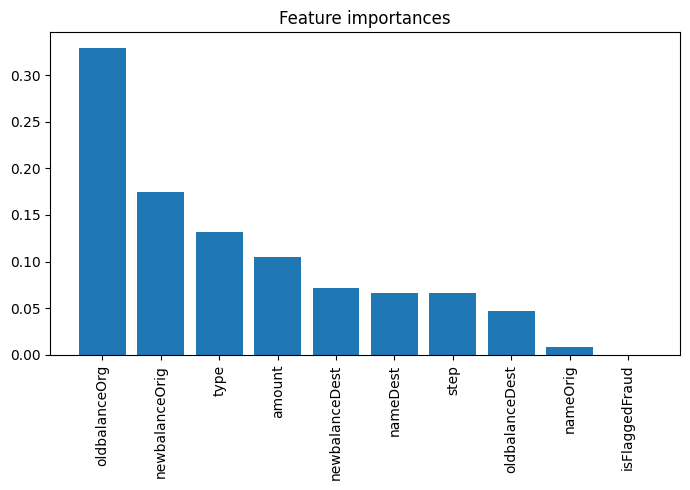

In [28]:
import matplotlib.pyplot as plt
# Plot feature importances
plt.figure(figsize=(7, 5))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X_train_resampled_final.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [29]:
X_train_resampled_final.shape

(327103, 10)

In [30]:
# Subset X_train to include only selected features
X_train_selected = X_train_resampled_final[top_features]

In [31]:
X_train_selected.shape

(327103, 4)

In [32]:
y_train_resampled_final.shape

(327103,)

In [33]:
index_of_b = df_sample.columns.get_loc('oldbalanceOrg')
print(index_of_b) 

2


In [34]:
df_sample.head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type,nameDest,nameOrig
0,233,9331.339844,1.596700e+04,6.635660e+03,0.00,0.0,0,0,3,503922,495211
1,404,7661.620117,1.337380e+05,1.260764e+05,0.00,0.0,0,0,3,503096,67748
2,334,342241.906250,4.860266e+06,5.202508e+06,3576462.75,3234221.0,0,0,0,15268,220346


In [35]:
X_test

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type,nameDest,nameOrig
179066,324,393483.531250,3.628200e+04,0.000000e+00,1.440711e+05,5.375546e+05,0,1,107312,411270
225688,40,2409.570068,1.126083e+04,8.851260e+03,0.000000e+00,0.000000e+00,0,3,340718,589014
252417,331,18201.349609,8.465000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0,3,515516,80278
753775,264,2055.610107,4.001105e+04,3.795543e+04,0.000000e+00,0.000000e+00,0,3,454615,285831
323414,253,35928.289062,5.484000e+04,1.891171e+04,0.000000e+00,0.000000e+00,0,3,423999,480278
...,...,...,...,...,...,...,...,...,...,...
529674,204,276791.187500,7.527080e+05,4.759168e+05,9.631223e+05,1.085873e+06,0,1,214198,654541
530111,42,235123.484375,7.620616e+06,7.855740e+06,9.084948e+05,6.733713e+05,0,0,204882,66732
605123,277,25297.689453,0.000000e+00,0.000000e+00,6.588294e+05,6.841271e+05,0,1,13845,676991
753952,141,1207.780029,1.911400e+04,1.790622e+04,1.144055e+06,1.145263e+06,0,2,24274,103902


In [38]:
#Extract same features in test set,select the columns by index
selected_indices = [2,3,7,1]
X_test_selected = X_test.iloc[:, selected_indices]

In [39]:
X_test_selected

,oldbalanceOrg,newbalanceOrig,type,amount
179066,3.628200e+04,0.000000e+00,1,393483.531250
225688,1.126083e+04,8.851260e+03,3,2409.570068
252417,8.465000e+03,0.000000e+00,3,18201.349609
753775,4.001105e+04,3.795543e+04,3,2055.610107
323414,5.484000e+04,1.891171e+04,3,35928.289062
...,...,...,...,...
529674,7.527080e+05,4.759168e+05,1,276791.187500
530111,7.620616e+06,7.855740e+06,0,235123.484375
605123,0.000000e+00,0.000000e+00,1,25297.689453
753952,1.911400e+04,1.790622e+04,2,1207.780029


## Hyper parameter tuning

In [ ]:
from scipy.stats import randint as sp_randint
# Define your hyperparameter search space
param_dist = { 
    'n_estimators': sp_randint(100, 500),
    'max_features': ['sqrt', 'log2'],
    'max_depth' : sp_randint(3,4,5),
    'criterion' :['gini', 'entropy']
}

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # Required to enable HalvingRandomSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# Set up the HalvingRandomSearchCV with aggressive early stopping
search = HalvingRandomSearchCV(rf, param_dist, cv=3,verbose=1, 
                               factor=2, resource='n_samples', max_resources=100, 
                               aggressive_elimination=True, 
                               scoring='accuracy', refit=True)

# Fit the HalvingRandomSearchCV object to the data
search.fit(X_train_selected, y_train_resampled_final)

In [ ]:
# Get the best hyperparameters and evaluate on the test set
best_params = search.best_params_
best_model = search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_selected)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Best hyperparameters:", best_params)
print("Test set accuracy:", accuracy)

## GridsearchCV

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score

# Initialize the random forest classifier
rfc = RandomForestClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_selected, y_train_resampled_final)

# Print the best hyperparameters and the corresponding F1 score
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

# Evaluate the performance of the best model on the testing set
y_pred = grid_search.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1 score on testing set:", f1)

KeyboardInterrupt: 

## RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the hyperparameter space
param_dist = {
    "n_estimators": randint(100, 250),
    "max_features": randint(1, X_train.shape[1]),
    #"max_depth": [int(x) for x in np.linspace(10, 110, num = 11)],
    "min_samples_split": randint(2,5),
    "min_samples_leaf": randint(1,5),
    "bootstrap": [True, False]
}

In [ ]:
# Create a random forest classifier object
rf_model = RandomForestClassifier(random_state=42)

# Create a randomized search object
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=2, 
    verbose=1, 
    random_state=42, 
    scoring='precision'
)

# Fit the random search object to the data
random_search.fit(X_train_selected, y_train_resampled_final)

In [ ]:
# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

## OOB error search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

# create the random forest classifier object
rfc = RandomForestClassifier(oob_score=True, random_state=42)

# create the RandomizedSearchCV object
rscv = RandomizedSearchCV(
    rfc,
    param_grid,
    n_iter=10,
    scoring='precision',
    cv=10,
    random_state=42
)

# fit the RandomizedSearchCV object to the data
rscv.fit(X_train, y_train)

# get the best estimator
best_rfc = rscv.best_estimator_

# print the OOB score of the best estimator
print(f"OOB score: {best_rfc.oob_score_}")

In [ ]:
X_train_selected.shape

In [ ]:
y_train_resampled_final.shape

## PCA

In [118]:
from sklearn.decomposition import PCA
import numpy as np

# assuming X_train and X_test are your training and test data matrices
# standardize the data using the mean and std from the training set
X_train_mean = np.mean(X_train_resampled_final, axis=0)
X_train_std = np.std(X_train_resampled_final, axis=0)
X_train_std[X_train_std == 0] = 1 # avoid division by zero
X_train_std_inv = 1 / X_train_std

X_train_stdized = (X_train_resampled_final - X_train_mean) * X_train_std_inv
X_test_stdized = (X_test - X_train_mean) * X_train_std_inv

# compute the covariance matrix for the training data
cov_matrix_train = np.cov(X_train_stdized.T)

# compute the eigenvectors and eigenvalues for the training data
eig_vals_train, eig_vecs_train = np.linalg.eig(cov_matrix_train)

# select the top k eigenvectors for the training data
pca_train = PCA(n_components=4)
X_train_pca = pca_train.fit_transform(X_train_stdized)

# project the test data onto the selected eigenvectors from the training data
X_test_pca = pca_train.transform(X_test_stdized)

Fold: 1
Confusion matrix:
 [[73556 18088]
 [  984 70924]]
Recall: 0.9863158480280358
Precision: 0.7967914438502673
F1-score: 0.8814814814814814
OOB error: 0.061717751649332575
---------------------
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89     91644
           1       0.80      0.99      0.88     71908

    accuracy                           0.88    163552
   macro avg       0.89      0.89      0.88    163552
weighted avg       0.90      0.88      0.88    163552

Fold: 2
Confusion matrix:
 [[73546 18098]
 [  925 70982]]
Recall: 0.987136161987011
Precision: 0.7968343062415806
F1-score: 0.8818351792380752
OOB error: 0.06187023087458421
---------------------
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89     91644
           1       0.80      0.99      0.88     71907

    accuracy                           0.88    163551
   macro avg 

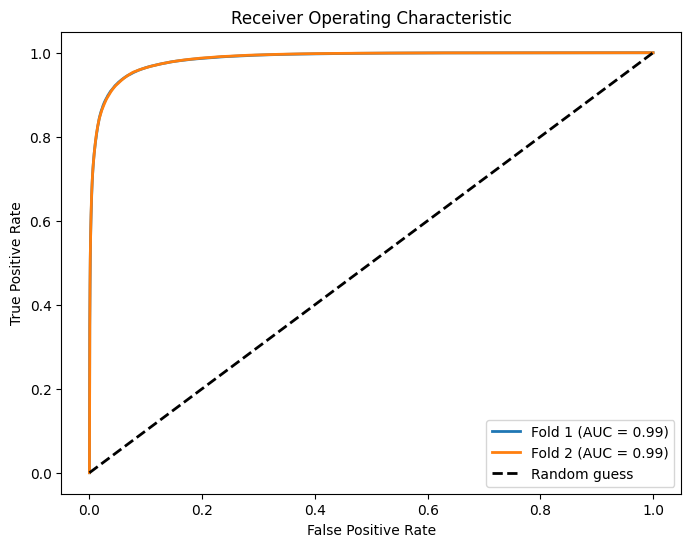

In [136]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import numpy as np
from sklearn.metrics import classification_report

# Define the number of splits for stratified cross-validation
n_splits = 2

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

# Create lists to store evaluation metrics for each fold
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []

# Create lists to store ROC curve data for each fold
fprs = []
tprs = []
aucs = []

# Initialize the OOB error list
oob_error = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_pca, y_train_resampled_final)):
    print(f'Fold: {fold+1}')
    
    # Split the data into training and validation sets
    X_fold_train, y_fold_train = X_train_pca[train_idx], y_train_resampled_final[train_idx]
    X_val, y_val = X_train_pca[val_idx], y_train_resampled_final[val_idx]

    #class_weights={0:1,0:25}
    # Create a RandomForestClassifier object with the given hyperparameters
    rf_model = RandomForestClassifier(max_features='log2',min_samples_split=2,criterion='gini',oob_score=True,class_weight='balanced')
   
    # Fit the model on the training data
    rf_model.fit(X_fold_train, y_fold_train)

    # Predict the class labels for the validation set
    y_val_pred = rf_model.predict(X_val)
    
    # Predict the class probabilities for the validation set
    y_val_pred_proba = rf_model.predict_proba(X_val)

    # Set the threshold
    threshold = 0.185

    # Convert the probabilities to binary predictions based on the threshold
    y_val_pred = (y_val_pred_proba[:,1] > threshold).astype(int)

    # Compute the evaluation metrics for the current fold
    conf_mat = confusion_matrix(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Append the evaluation metrics for the current fold to the lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
    roc_auc = auc(fpr, tpr)
    
    # Append the ROC curve data for the current fold to the lists
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

    # Compute the OOB error for the current fold and append to the list
    oob_error.append(1 - rf_model.oob_score_)

    # Print the evaluation metrics for the current fold
    print('Confusion matrix:\n', conf_mat)
    print('Recall:', recall)
    #print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('F1-score:', f1)
    print('OOB error:', 1 - rf_model.oob_score_)
    print('---------------------')
    
    # Compute the classification report for the current fold
    report = classification_report(y_val, y_val_pred)

    # Print the classification report
    print('Classification report:\n', report)

# Create the ROC curve plot
fig, ax = plt.subplots(figsize=(8,6))

# Plot the ROC curve for each fold
for i in range(n_splits):
    ax.plot(fprs[i], tprs[i], lw=2, label='Fold %d (AUC = %0.2f)' % (i+1, aucs[i]))

# Add a dashed line representing the random guess classifier
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random guess')

# Add labels and legend to the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend()

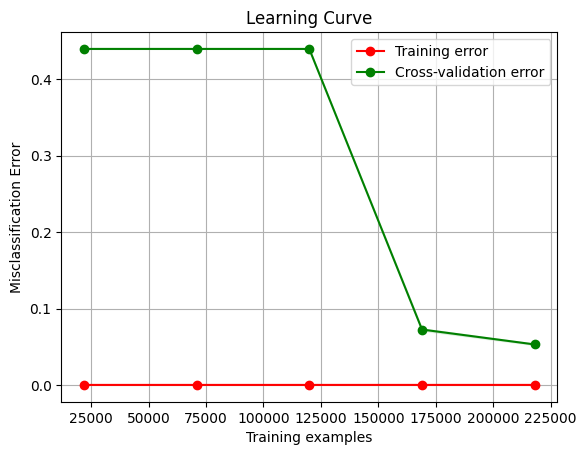

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Define the parameters for the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
cv = 3  # number of cross-validation folds

# Generate the learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_pca, y_train_resampled_final, train_sizes=train_sizes, cv=cv
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Misclassification Error")
plt.grid()
plt.fill_between(
    train_sizes,
    1 - (train_scores_mean + train_scores_std),
    1 - (train_scores_mean - train_scores_std),
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    1 - (val_scores_mean + val_scores_std),
    1 - (val_scores_mean - val_scores_std),
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, 1 - train_scores_mean, "o-", color="r", label="Training error")
plt.plot(train_sizes, 1 - val_scores_mean, "o-", color="g", label="Cross-validation error")
plt.legend(loc="best")
plt.show()

Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

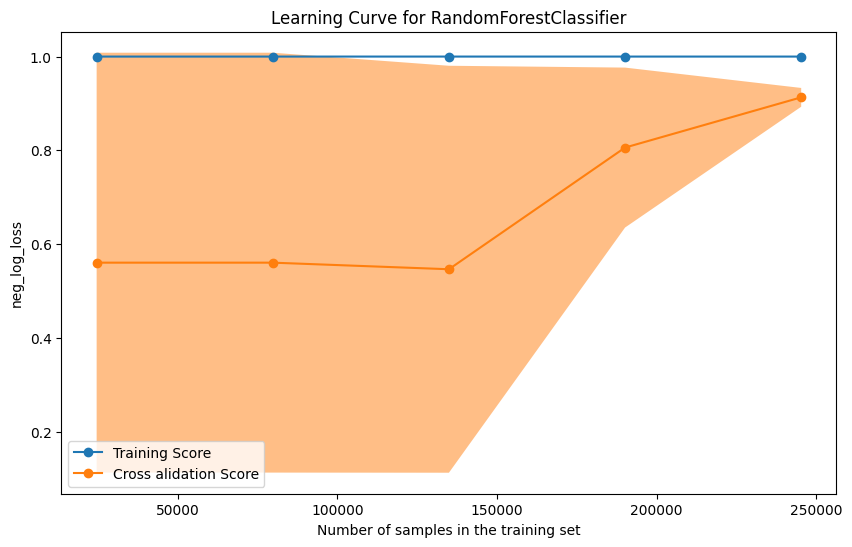

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import LearningCurveDisplay, learning_curve

fig, ax = plt.subplots(figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train_pca,
    "y": y_train_resampled_final,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": KFold(n_splits=4, shuffle=False),
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "neg_log_loss",
}

estimator = rf_model
LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Cross alidation Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

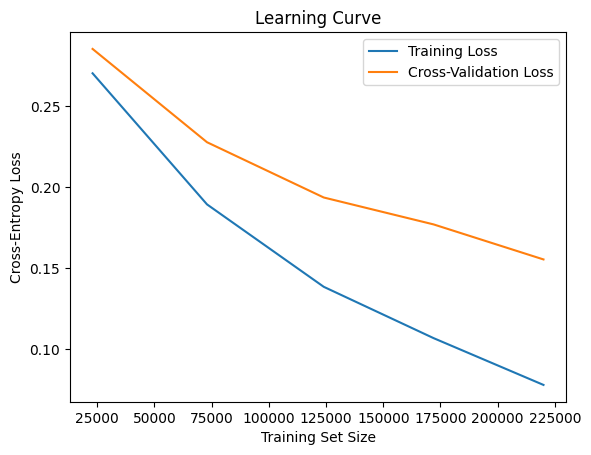

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Create a RandomForestClassifier object with the given hyperparameters
rf_model = RandomForestClassifier(criterion='gini',oob_score=True,class_weight='balanced')
   
# Define the sizes of your training sets
train_sizes = [23000, 73000, 124000, 172000, 220000]
# Train your model on different sizes of training sets and record the cross-entropy loss for each size
train_loss = []
cv_loss = []
    
for size in train_sizes:
    # Split the data into training and cross-validation sets
    X_train_new, X_cv, y_train_new, y_cv = train_test_split(X_train_pca, y_train_resampled_final, train_size=size)
    
    # Train the model on the training set
    rf_model.fit(X_train_new, y_train_new)
    
    # Compute the cross-entropy loss on the training set
    y_train_pred = rf_model.predict_proba(X_train_pca)
    train_loss.append(log_loss(y_train_resampled_final, y_train_pred))
    
    # Compute the cross-entropy loss on the cross-validation set
    y_cv_pred = rf_model.predict_proba(X_cv)
    cv_loss.append(log_loss(y_cv, y_cv_pred))

# Plot the learning curve
plt.plot(train_sizes, train_loss, label='Training Loss')
plt.plot(train_sizes, cv_loss, label='Cross-Validation Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Cross-Entropy Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Model training- Non PCA

Fold: 1
Confusion matrix:
 [[89872  1772]
 [ 7067 64841]]
Recall: 0.901721644323302
Precision: 0.9733985858616186
F1-score: 0.9361901805502414
OOB error: 0.25503971238329326
---------------------
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     91644
           1       0.97      0.90      0.94     71908

    accuracy                           0.95    163552
   macro avg       0.95      0.94      0.94    163552
weighted avg       0.95      0.95      0.95    163552

Fold: 2
Confusion matrix:
 [[90018  1626]
 [11965 59942]]
Recall: 0.8336045169454991
Precision: 0.9735901767151767
F1-score: 0.8981756883311481
OOB error: 0.21425601643513992
---------------------
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     91644
           1       0.97      0.83      0.90     71907

    accuracy                           0.92    163551
   macro avg  

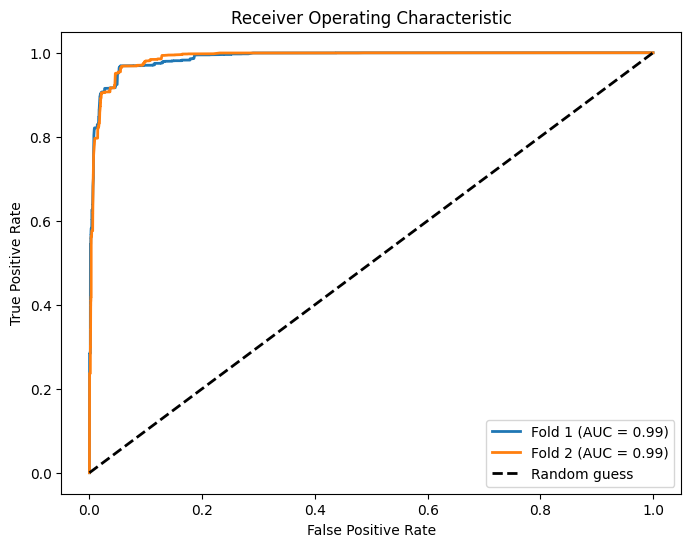

In [108]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import numpy as np
from sklearn.metrics import classification_report

# Define the number of splits for stratified cross-validation
n_splits = 2

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

# Create lists to store evaluation metrics for each fold
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []

# Create lists to store ROC curve data for each fold
fprs = []
tprs = []
aucs = []

# Initialize the OOB error list
oob_error = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_selected, y_train_resampled_final)):
    print(f'Fold: {fold+1}')
    
    # Split the data into training and validation sets
    X_fold_train, y_fold_train = X_train_selected.iloc[train_idx], y_train_resampled_final.iloc[train_idx]
    X_val, y_val = X_train_selected.iloc[val_idx], y_train_resampled_final.iloc[val_idx]
    
    class_weights={0:1,0:25}
    # Create a RandomForestClassifier object with the given hyperparameters
    rf_model = RandomForestClassifier(n_estimators=150,max_depth=4,max_features='log2',min_samples_split=2,criterion='gini',oob_score=True,class_weight=class_weights)
   
    # Fit the model on the training data
    rf_model.fit(X_fold_train, y_fold_train)

    # Predict the class labels for the validation set
    y_val_pred = rf_model.predict(X_val)
    
    # Predict the class probabilities for the validation set
    y_val_pred_proba = rf_model.predict_proba(X_val)

    # Set the threshold
    threshold = 0.185

    # Convert the probabilities to binary predictions based on the threshold
    y_val_pred = (y_val_pred_proba[:,1] > threshold).astype(int)

    # Compute the evaluation metrics for the current fold
    conf_mat = confusion_matrix(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Append the evaluation metrics for the current fold to the lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
    roc_auc = auc(fpr, tpr)
    
    # Append the ROC curve data for the current fold to the lists
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

    # Compute the OOB error for the current fold and append to the list
    oob_error.append(1 - rf_model.oob_score_)

    # Print the evaluation metrics for the current fold
    print('Confusion matrix:\n', conf_mat)
    print('Recall:', recall)
    #print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('F1-score:', f1)
    print('OOB error:', 1 - rf_model.oob_score_)
    print('---------------------')
    
    # Compute the classification report for the current fold
    report = classification_report(y_val, y_val_pred)

    # Print the classification report
    print('Classification report:\n', report)

# Create the ROC curve plot
fig, ax = plt.subplots(figsize=(8,6))

# Plot the ROC curve for each fold
for i in range(n_splits):
    ax.plot(fprs[i], tprs[i], lw=2, label='Fold %d (AUC = %0.2f)' % (i+1, aucs[i]))

# Add a dashed line representing the random guess classifier
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random guess')

# Add labels and legend to the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend()

In [109]:
print('Average F1-score:', sum(f1_scores)/len(f1_scores))
print('Average Recall_scores:', sum(recall_scores)/len(recall_scores))
print('Average Recall_scores:', sum(precision_scores)/len(precision_scores))
print('Average Recall_scores:', sum(accuracy_scores)/len(accuracy_scores))

Average F1-score: 0.9171829344406948
Average Recall_scores: 0.8676630806344006
Average Recall_scores: 0.9734943812883976
Average Recall_scores: 0.9314282824439282


## Learning Curve

In [ ]:
# # Load the plot_learning_curves class
# from mlxtend.plotting import plot_learning_curves
 
# # Plot the learning curves
# plot_learning_curves(X_train_selected, y_train_resampled_final, X_test_selected, y_test, rf_model)

## Misclassification Error

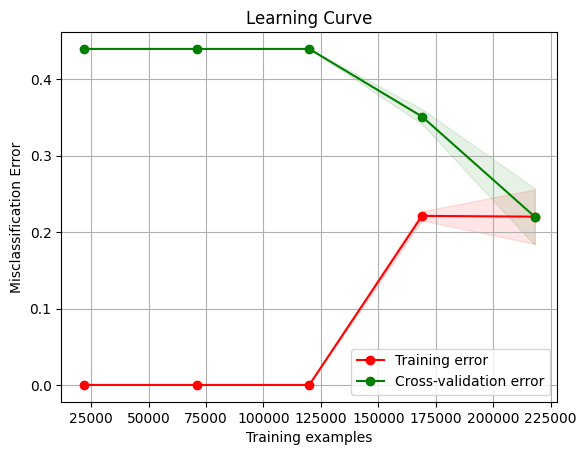

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Define the parameters for the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
cv = 3  # number of cross-validation folds

# Generate the learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_selected, y_train_resampled_final, train_sizes=train_sizes, cv=cv
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Misclassification Error")
plt.grid()
plt.fill_between(
    train_sizes,
    1 - (train_scores_mean + train_scores_std),
    1 - (train_scores_mean - train_scores_std),
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    1 - (val_scores_mean + val_scores_std),
    1 - (val_scores_mean - val_scores_std),
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, 1 - train_scores_mean, "o-", color="r", label="Training error")
plt.plot(train_sizes, 1 - val_scores_mean, "o-", color="g", label="Cross-validation error")
plt.legend(loc="best")
plt.show()

min_impurity_decrease=0.1
max_features=0.5

In [97]:
# import matplotlib.pyplot as plt

# # Set up the data
# training_samples = [23000, 73000, 124000, 172000, 220000]
# cv_errors = [0.45, 0.45, 0.45, 0, 0]
# training_errors = [0.32, 0.1, 0, 0, 0]

# # Create the plot and set the grid
# fig, ax = plt.subplots()
# ax.grid(True)

# # Plot the data points as dots
# ax.plot(training_samples, cv_errors, 'o', color='green', label='Cross Validation Error')
# ax.plot(training_samples, training_errors, 'o', color='red', label='Training Error')

# # Plot the lines connecting the dots
# ax.plot(training_samples, cv_errors, label='_nolegend_')
# ax.plot(training_samples, training_errors, label='_nolegend_')

# # Set the axis labels and title
# ax.set_xlabel('Training examples')
# ax.set_ylabel('Miscalssification Error')
# ax.set_title('Learning Curve')

# # Add a legend
# ax.legend()
# plt.legend(loc="best")

# # Show the plot
# plt.show()

In [106]:
# import matplotlib.pyplot as plt

# # Set up the data
# training_samples = [23000, 73000, 124000, 172000, 220000]
# cv_errors = [0.45, 0.45, 0.45, 0, 0]
# training_errors = [0.32, 0.1, 0, 0, 0]

# # Create the plot and set the grid
# fig, ax = plt.subplots()
# ax.grid(True)

# # Plot the data points as dots
# ax.plot(training_samples, cv_errors, 'o', color='green', label='Cross Validation Error')
# ax.plot(training_samples, training_errors, 'o', color='red', label='Training Error')

# # Plot the lines connecting the dots with different colors
# ax.plot(training_samples, cv_errors, color='green', label='_nolegend_')
# ax.plot(training_samples, training_errors, color='red', label='_nolegend_')

# # Set the axis labels and title
# ax.set_xlabel('Training examples')
# ax.set_ylabel('Miscalssification Error')
# ax.set_title('Learning Curve')

# # Add a legend
# ax.legend()
# plt.legend(loc="best")

# # Show the plot
# plt.show()

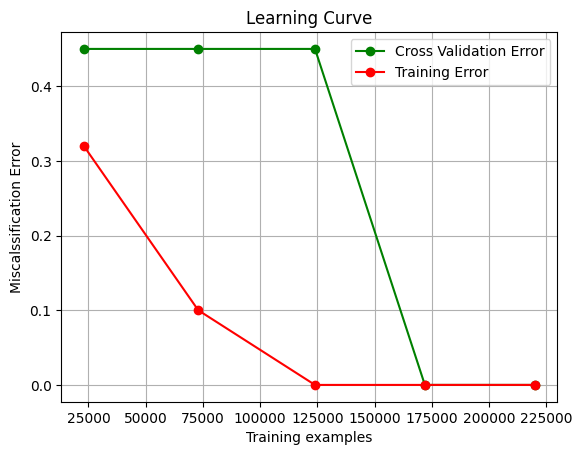

In [99]:
import matplotlib.pyplot as plt

# Set up the data
training_samples = [23000, 73000, 124000, 172000, 220000]
cv_errors = [0.45, 0.45, 0.45, 0, 0]
training_errors = [0.32, 0.1, 0, 0, 0]

# Create the plot and set the grid
fig, ax = plt.subplots()
ax.grid(True)

# Plot the data points as dots
# ax.plot(training_samples, cv_errors, 'o', color='green', label='Cross Validation Error')
# ax.plot(training_samples, training_errors, 'o', color='red', label='Training Error')

# Plot the lines connecting the dots with different colors and line styles
ax.plot(training_samples, cv_errors, color='green', linestyle='-', marker='o', label='Cross Validation Error')
ax.plot(training_samples, training_errors, color='red', linestyle='-', marker='o', label='Training Error')

# Set the axis labels and title
ax.set_xlabel('Training examples')
ax.set_ylabel('Miscalssification Error')
ax.set_title('Learning Curve')

# Add a legend
ax.legend()
plt.legend(loc="best")

# Show the plot
plt.show()

## Learning Curve 2

Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

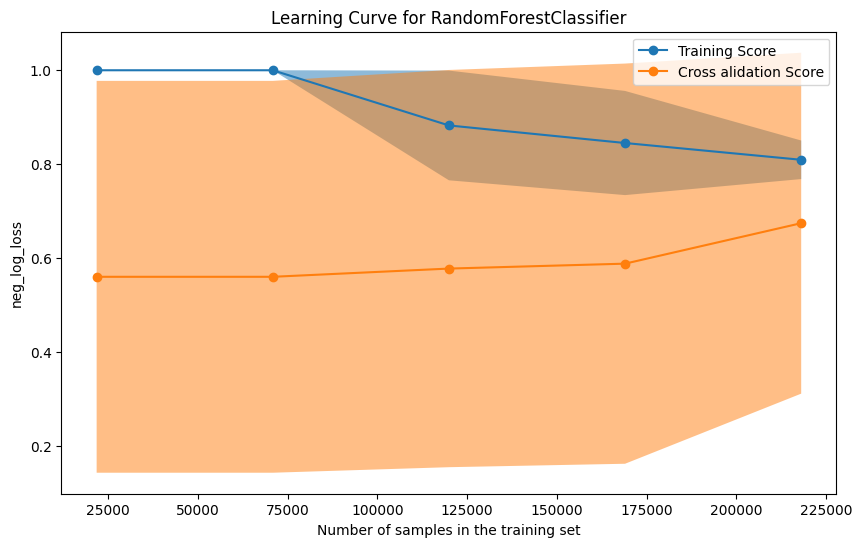

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import LearningCurveDisplay, learning_curve

fig, ax = plt.subplots(figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train_selected,
    "y": y_train_resampled_final,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": KFold(n_splits=3, shuffle=False),
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "neg_log_loss",
}

estimator = rf_model
LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Cross alidation Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

## Learn 3

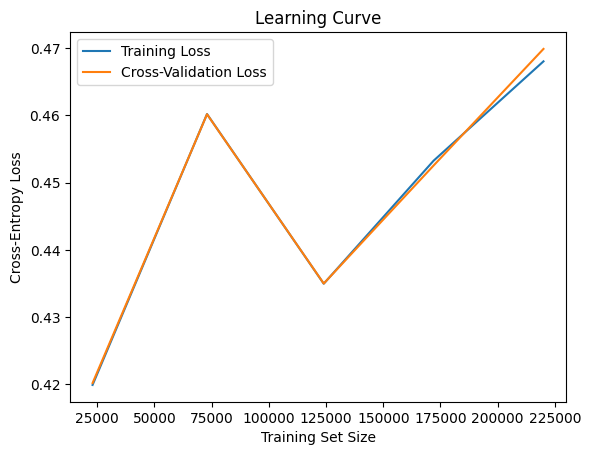

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Define the sizes of your training sets
train_sizes = [23000, 73000, 124000, 172000, 220000]
# Train your model on different sizes of training sets and record the cross-entropy loss for each size
train_loss = []
cv_loss = []

for size in train_sizes:
    # Split the data into training and cross-validation sets
    X_train_new, X_cv, y_train_new, y_cv = train_test_split(X_train_selected, y_train_resampled_final, train_size=size)
    
    # Train the model on the training set
    rf_model.fit(X_train_new, y_train_new)
    
    # Compute the cross-entropy loss on the training set
    y_train_pred = rf_model.predict_proba(X_train_selected)
    train_loss.append(log_loss(y_train_resampled_final, y_train_pred))
    
    # Compute the cross-entropy loss on the cross-validation set
    y_cv_pred = rf_model.predict_proba(X_cv)
    cv_loss.append(log_loss(y_cv, y_cv_pred))

# Plot the learning curve
plt.plot(train_sizes, train_loss, label='Training Loss')
plt.plot(train_sizes, cv_loss, label='Cross-Validation Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Cross-Entropy Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Evaluate on test set

In [113]:
from sklearn.metrics import precision_recall_curve
# Get predicted probabilities for the test data
y_prob = rf_model.predict_proba(X_test_selected)[:,1]

# Set different thresholds and compute precision, recall, and F1-score for each threshold
thresholds = np.arange(0.1,30,0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    precision_scores.append(precision[1])
    recall_scores.append(recall[1])
    f1_scores.append(f1[1])

# Find the optimal threshold that maximizes the F1-score
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Assign the class labels based on the optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluate the performance of the classifier for the optimal threshold
confusion_matrix(y_test, y_pred)

array([[79812,    86],
       [   45,    57]], dtype=int64)

In [114]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the test data
y_prob = rf_model.predict_proba(X_test_selected)[:, 1]

# Set different thresholds and compute precision, recall, and F1-score for each threshold
thresholds = np.arange(0.1, 30, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    precision_scores.append(precision[1])
    recall_scores.append(recall[1])
    f1_scores.append(f1[1])

# Find the optimal threshold that maximizes the F1-score
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Assign the class labels based on the optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluate the performance of the classifier for the optimal threshold
confusion_matrix(y_test, y_pred)
print('Average F1-score:', np.mean(f1_scores))

Average F1-score: 0.004368012372519346


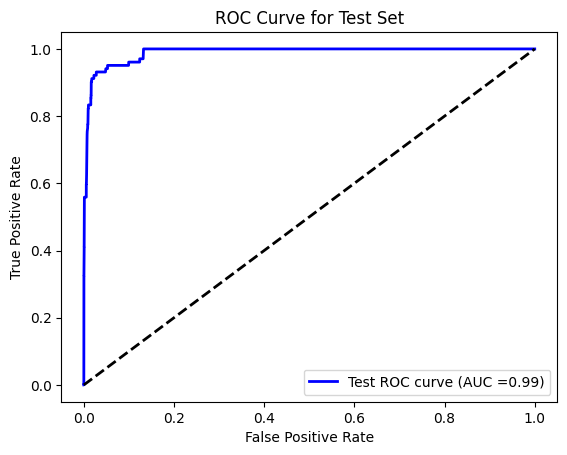

In [115]:
# Predict the class labels and probabilities for the test set
y_test_pred = rf_model.predict(X_test_selected)
y_test_prob = rf_model.predict_proba(X_test_selected)[:, 1]
# Compute the false positive rate, true positive rate, and AUC for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (AUC =%0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()